In [1]:
import numpy as np
import tensorflow as tf
import os
import blosc

from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset

from tqdm import tqdm_notebook as tqn

In [5]:
src = './../MNIST_data/'

In [6]:
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())

In [7]:
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())

In [8]:
src = (full_imgs, full_labs)

### Set up mnist-dataset and pipeline

In [9]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

In [10]:
mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

### Train nn

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
stats = []

In [13]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       shift_flattened_pic().
       train_convy(sess))

In [14]:
# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            shift_flattened_pic().
            update_stats(sess, stats))

In [29]:
for i in tqn(range(400)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)

### Plots

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

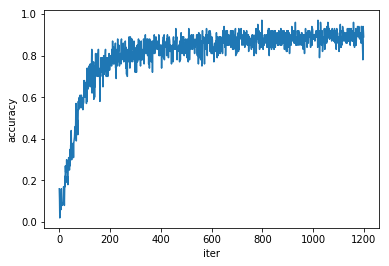

In [31]:
plt.plot(stats)
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

In [33]:
dict_pred = {'predict': [],
          'answer': [],
          'imgs': []}
(mnistset.test
    .p
    .load(src=src, fmt='ndarray')
    .prediction(sess,dict_pred)
    .run(1, n_epochs=1))

In [34]:
print('Accuracy without shift: ', np.sum(dict_pred['answer'])/len(dict_pred['predict']))

Accuracy without shift:  0.927846153846


In [35]:
dict_p = {'predict': [],
          'answer': [],
          'imgs': []}
pred_sh =[]
answer_sh = []
imgs_sh = []
(mnistset.test
    .p
    .load(src=src, fmt='ndarray')
    .shift_flattened_pic()
    .prediction(sess, dict_p)
    .run(1, n_epochs=1))

In [36]:
print('Accuracy with shift: ', np.sum(dict_p['answer'])/len(dict_p['predict']))

Accuracy with shift:  0.887384615385


### На каких цифрах мы ошибаемся

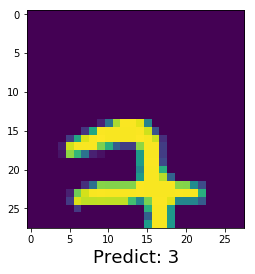

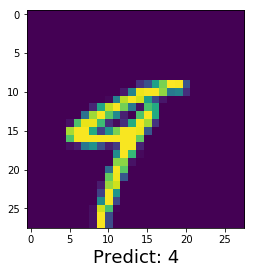

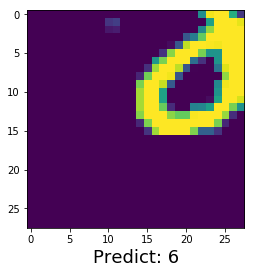

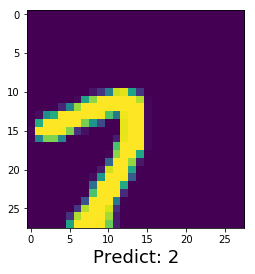

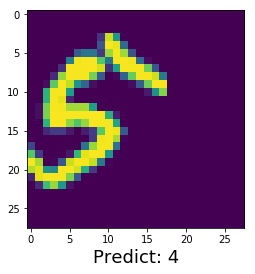

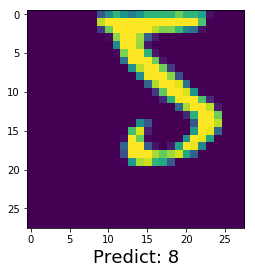

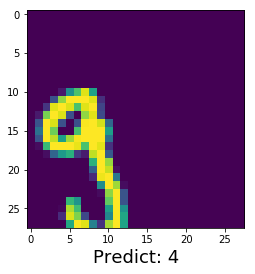

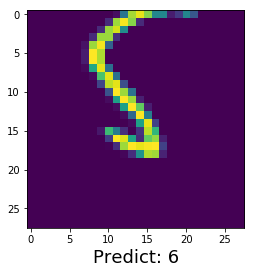

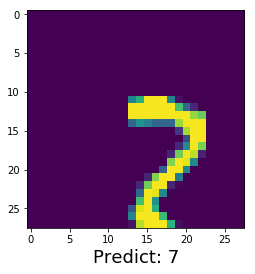

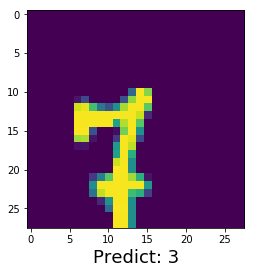

In [37]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,4)

for i in range(10):
    fig = plt.figure()
    index = np.where(np.array(dict_p['answer']).reshape(-1) == False)[0][i]
    plt.imshow(dict_p['imgs'][index].reshape(-1,28))
    plt.xlabel('Predict: {}'.format(np.argmax(dict_p['predict'][index])), fontsize=18)